In [1]:
import pickle
import copy
from experiments import *
from utils import *

Definitions

In [2]:
scenarios = {'cnn':['summarization_cnndm:temperature=0.3,device=cuda,'], 
             'xsum':['summarization_xsum:temperature=0.3,device=cuda,'], 
             'boolq:':['boolq:'],
             'civil_comments':['civil_comments:demographic=LGBTQ,',
                               'civil_comments:demographic=all,',
                               'civil_comments:demographic=black,',
                               'civil_comments:demographic=christian,',
                               'civil_comments:demographic=female,',
                               'civil_comments:demographic=male,',
                               'civil_comments:demographic=muslim,',
                               'civil_comments:demographic=other_religions,',
                               'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             'narrative_qa:':['narrative_qa:'],
             'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            
scenarios_metrics = {'boolq:':'em', 
                     'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':'em',
                     'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':'em',
                     'imdb:':'em', 
                     'mmlu':'em', 
                     'msmarco:track=regular,valid_topk=30,':'RR@10', 
                     'msmarco:track=trec,valid_topk=30,':'NDCG@10', 
                     'narrative_qa:':'f1', 
                     'natural_qa:mode=closedbook,':'f1', 
                     'natural_qa:mode=openbook_longans,':'f1', 
                     'quac:':'f1', 
                     'raft':'em', 
                     'truthful_qa:task=mc_single,method=multiple_choice_joint,':'em'}

## Data

Loading data

In [3]:
with open('data/helm.pickle', 'rb') as handle:
    data = pickle.load(handle)

## Results

In [4]:
device = 'cuda'
iterations = 10
Ds = [1, 5, 10, 15, 20] #

num_elements = 4
set_of_rows = [[0,1,2,3], #ai21
               [5,6,7,8,9,10,11], #cohere
               [4,12,13], #anthropic+microsoft
               [14,15,16,17,18,19,20,21,22], #openai
               [23,24,25,26,27]] #together
set_of_rows

[[0, 1, 2, 3],
 [5, 6, 7, 8, 9, 10, 11],
 [4, 12, 13],
 [14, 15, 16, 17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27]]

In [527]:
scenario_name = 'full' #we are evaluating all scenarios at once
chosen_scenarios = list(scenarios.keys())
bench ='irt_helm'
    
lambds = [None] + np.round(np.linspace(0,1,10),2).tolist()  # Lambda values to consider
number_items = [10, 25, 50, 75, 100]  # Number of items to consider in evaluations

cpu = mp.cpu_count()  # Number of available CPU cores
epochs = 2000  # Number of epochs for IRT model training (package default is 2000)
lr = .1  # Learning rate for IRT model training (package default is .1)

accs = {}  # Initialize a dictionary to hold accuracies
results = {}  # Initialize a dictionary to hold results

# Iterate through each set of rows to hide
rows_to_hide = set_of_rows[4]
rows_to_hide_str = ':'.join([str(r) for r in rows_to_hide])

print(f"\nEvaluating models {rows_to_hide}")
        
# Prepare data and scenarios
scenarios_position, subscenarios_position = prepare_data(chosen_scenarios, scenarios, data)
scores = create_responses(chosen_scenarios, scenarios, data)
        
balance_weights = np.ones(scores.shape[1]) #for scenario=='civil_comments', some items need to be downweighted, for other scenarios not
if 'civil_comments' in chosen_scenarios:
    balance_weights[scenarios_position['civil_comments']] = scores[:,scenarios_position['civil_comments']].max(axis=0)
    #(balance_weights==0).sum(axis=0) verifying that no item had weight 0 (the output should be zero)
    scores[:,scenarios_position['civil_comments']] = (scores[:,scenarios_position['civil_comments']]>0).astype(float)

# Create training and test sets by hiding specific rows
scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
responses_train = np.zeros(scores_train.shape)
responses_test = np.zeros(scores_test.shape)

# Threshold responses 
cs = np.linspace(0.01,.99,1000)  # Threshold values to consider
for scenario in chosen_scenarios:
    ind = scenarios_position[scenario]
    # Find the best threshold value that minimizes the difference between mean responses and mean scores
    c = cs[np.argmin([np.mean((np.abs((scores_train[:,ind]>c).mean(axis=1)-scores_train[:,ind].mean(axis=1)))) for c in cs])]
    # Apply the threshold to train and test responses
    responses_train[:,ind] = (scores_train[:,ind]>c).astype(int)
    responses_test[:,ind] = (scores_test[:,ind]>c).astype(int)

# Transforming scores back
scores = balance_weights*scores
scores_train = scores[[i for i in range(scores.shape[0]) if i not in rows_to_hide]]
scores_test = scores[[i for i in range(scores.shape[0]) if i in rows_to_hide]]
#print("shape of scores=",scores.shape, "shape of scores train=",scores_train.shape,"shape of scores test=",scores_test.shape)


Evaluating models [23, 24, 25, 26, 27]


In [545]:
model_name = f'models/{bench}/row-{rows_to_hide_str}_D-validate_scenario-{scenario_name}/'
A, B, Theta = load_irt_parameters(model_name)

In [546]:
E = np.hstack((A,B))
E.shape

(1, 16, 20620)

In [530]:
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need
       

In [531]:
def sigmoid(z):
    
    """
    Compute the sigmoid function for the input z.
    
    Parameters:
    - z: A numeric value or numpy array.
    
    Returns:
    - The sigmoid of z.
    """
    
    return 1/(1+np.exp(-z))

def item_curve(theta, a, b):
    
    """
    Compute the item response curve for given parameters.
    
    Parameters:
    - theta: The ability parameter of the subject.
    - a: The discrimination parameter of the item.
    - b: The difficulty parameter of the item.
    
    Returns:
    - The probability of a correct response given the item parameters and subject ability.
    """
    
    z = np.clip(a*theta - b, -30, 30).sum(axis=1)
    return sigmoid(z)

def neg_log_like(E, Theta=Theta, shape=E.shape, responses_train=responses_train, eps=1e-20):
    E = E.reshape(shape)
    A, B = E[:,:-1,:], E[:,-1,:]
    
    P = item_curve(Theta, A, B).squeeze()
    log_likelihood = np.mean(responses_train * np.log(P + eps) + (1 - responses_train) * np.log(1 - P + eps))
    return -log_likelihood

In [550]:
import autograd.numpy as np
from autograd import grad

def debias_irt(A, B, Theta, responses_train, max_iter=500, lr=100000, alpha=0.5, beta=0.9):
    E_initial = np.hstack((A,B))
    
    def neg_log_like(E, Theta=Theta, shape=E_initial.shape, responses_train=responses_train, eps=1e-20):
        E = E.reshape(shape)
        A, B = E[:, :-1, :], E[:, -1, :]
        P = item_curve(Theta, A, B).squeeze()
        log_likelihood = np.mean(responses_train * np.log(P + eps) + (1 - responses_train) * np.log(1 - P + eps))
        return -log_likelihood

    gradient = grad(neg_log_like)
    E = E_initial.copy()

    for it in range(max_iter):
        current_E = E.copy()
        grad_E = gradient(E.reshape(-1)).reshape(E.shape)
        initial_descent = -alpha * np.sum(grad_E**2)

        # Backtracking line search
        while neg_log_like(E - lr * grad_E) > neg_log_like(current_E) + lr * initial_descent:
            lr *= beta

        # Gradient update
        E -= lr * grad_E

        #if it % 50 == 0:
        #    print(neg_log_like(E))

    A, B = E[:, :-1, :], E[:, -1, :].reshape(1,1,-1)
    return A, B

A2, B2 = debias_irt(A, B, Theta, responses_train)

0.15729826521865808
0.1509422110151822
0.14823821473620505
0.14578773420609767
0.14352787942365
0.14142258133862645
0.13944709122476626
0.13758311574451243
0.13581652498527563
0.1341360653692775


In [551]:
A.shape,A2.shape

((1, 15, 20620), (1, 15, 20620))

In [552]:
B.shape,B2.shape

((1, 1, 20620), (1, 1, 20620))

In [535]:
np.abs(E-np.hstack((A,B))).mean()


0.05959395896262

In [536]:
np.sqrt((gradient(E.reshape(-1))**2).sum())

0.00022783998997660555

In [537]:
seen = list(range(0,responses_test.shape[1],2))
unseen = [i for i in range(responses_test.shape[1]) if i not in seen]

In [538]:
thetas = [estimate_ability_parameters(responses_test[j], seen, A, B) for j in range(responses_test.shape[0])]

In [539]:
thetas2 = [estimate_ability_parameters(responses_test[j], seen, E[:,:-1,:], E[:,-1,:].reshape((1,1,-1))) for j in range(responses_test.shape[0])]

In [540]:
100*np.mean(np.abs(item_curve(np.vstack(thetas), A[:,:,unseen], B[:,:,unseen]).squeeze().mean(axis=1)-scores_test[:,unseen].mean(axis=1)))

10.35190703814771

In [541]:
100*np.mean(np.abs(item_curve(np.vstack(thetas2), E[:,:-1,:][:,:,unseen], E[:,-1,:].reshape((1,1,-1))[:,:,unseen]).squeeze().mean(axis=1)-scores_test[:,unseen].mean(axis=1)))

10.041497810596125

In [542]:
diffs =[ ]
for scenario in scenarios.keys():
    unseen_scenario = [u for u in unseen if u in scenarios_position[scenario]]
    x1=100*np.mean(np.abs(item_curve(np.vstack(thetas), A[:,:,unseen_scenario], B[:,:,unseen_scenario]).squeeze().mean(axis=1)-scores_test[:,unseen_scenario].mean(axis=1)))
    x2=100*np.mean(np.abs(item_curve(np.vstack(thetas2), E[:,:-1,:][:,:,unseen_scenario], E[:,-1,:].reshape((1,1,-1))[:,:,unseen_scenario]).squeeze().mean(axis=1)-scores_test[:,unseen_scenario].mean(axis=1)))
    print(scenario, x1)
    print(scenario, x2)
    diffs.append(x1-x2)

cnn 2.5729134673595833
cnn 2.400925240812155
xsum 2.2356102630702113
xsum 2.440772505461089
boolq: 4.413666506292797
boolq: 4.240679740155131
civil_comments 22.503194594839975
civil_comments 22.147173745118792
commonsense:dataset=hellaswag,method=multiple_choice_separate_original, 2.0083333797046587
commonsense:dataset=hellaswag,method=multiple_choice_separate_original, 1.6358869308340427
commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated, 4.208097660062251
commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated, 3.8306699573355014
imdb: 6.338647812610379
imdb: 5.654125859783945
mmlu 3.372680951776795
mmlu 3.7996783686375615
msmarco:track=regular,valid_topk=30, 3.020398282160407
msmarco:track=regular,valid_topk=30, 2.865614063896871
narrative_qa: 2.2643725623236577
narrative_qa: 1.992434683629272
natural_qa:mode=closedbook, 4.223653598864474
natural_qa:mode=closedbook, 4.201552656857883
natural_qa:mode=openbook_longans, 3.3200393299113395
natura

In [543]:
np.mean(diffs)

0.1419845841149502

### Predicting accuracy

Full (one IRT model for all scenarios)

In [5]:
scenario_name = 'full' #we are evaluating all scenarios at once
chosen_scenarios = list(scenarios.keys())
results_full, accs_full = evaluate_scenarios(data, scenario_name, chosen_scenarios, scenarios, set_of_rows, Ds, iterations, device, bench='irt_helm')


Evaluating models [0, 1, 2, 3]

i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [02:07<00:00, 25.60s/it]


- opt D= 10 errors= [0.06503688293077949, 0.04475614032121996, 0.024061548280570562, 0.02460408352349725, 0.023851234004952593] 


ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 15/15 [34:40<00:00, 138.71s/it]


{'random_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor-irt_g

100%|█████████████████████████████████████████████| 5/5 [04:27<00:00, 53.55s/it]



Evaluating models [5, 6, 7, 8, 9, 10, 11]

i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [01:07<00:00, 13.42s/it]


- opt D= 20 errors= [0.0646544370062135, 0.05400272676563576, 0.05242562038617328, 0.048616678751919086, 0.03797297625970674] 


ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 15/15 [29:16<00:00, 117.09s/it]


{'random_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor-irt_g

100%|█████████████████████████████████████████████| 5/5 [06:51<00:00, 82.27s/it]



Evaluating models [4, 12, 13]

i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [02:30<00:00, 30.02s/it]


- opt D= 15 errors= [0.050405316409986384, 0.03336794682638223, 0.039927880314485194, 0.019742238670627087, 0.019129723877474355] 


ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 15/15 [33:21<00:00, 133.43s/it]


{'random_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor-irt_g

100%|█████████████████████████████████████████████| 5/5 [02:53<00:00, 34.64s/it]



Evaluating models [14, 15, 16, 17, 18, 19, 20, 21, 22]

i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [02:55<00:00, 35.04s/it]


- opt D= 15 errors= [0.06410567540630943, 0.03315561580061955, 0.028543245738186142, 0.025244242299085094, 0.02776584136204164] 


ii) choosing optimal lambdas


100%|███████████████████████████████████████████| 15/15 [24:47<00:00, 99.15s/it]


{'random_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor-irt_g

100%|████████████████████████████████████████████| 5/5 [08:32<00:00, 102.43s/it]



Evaluating models [23, 24, 25, 26, 27]

i) choosing optimal D


100%|█████████████████████████████████████████████| 5/5 [02:37<00:00, 31.50s/it]


- opt D= 20 errors= [0.06284322651413873, 0.052631086432144064, 0.05169161735162637, 0.025742261310686455, 0.019547377246908925] 


ii) choosing optimal lambdas


100%|██████████████████████████████████████████| 15/15 [29:58<00:00, 119.93s/it]


{'random_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor_gpirt': {'cnn': {}, 'xsum': {}, 'boolq:': {}, 'civil_comments': {}, 'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,': {}, 'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,': {}, 'imdb:': {}, 'mmlu': {}, 'msmarco:track=regular,valid_topk=30,': {}, 'narrative_qa:': {}, 'natural_qa:mode=closedbook,': {}, 'natural_qa:mode=openbook_longans,': {}, 'quac:': {}, 'raft': {}, 'truthful_qa:task=mc_single,method=multiple_choice_joint,': {}}, 'anchor-irt_g

100%|█████████████████████████████████████████████| 5/5 [04:48<00:00, 57.66s/it]


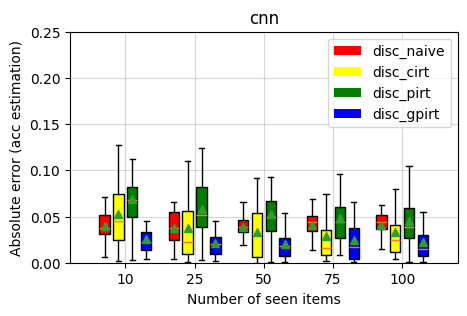

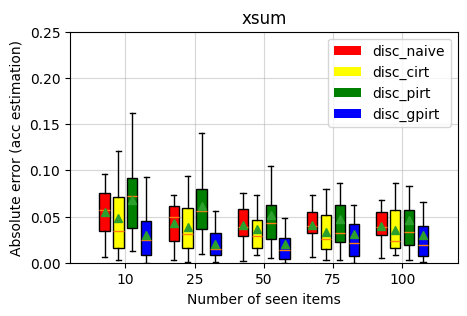

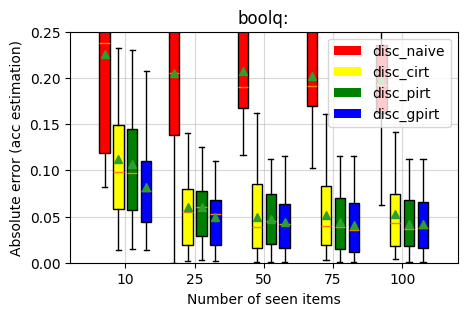

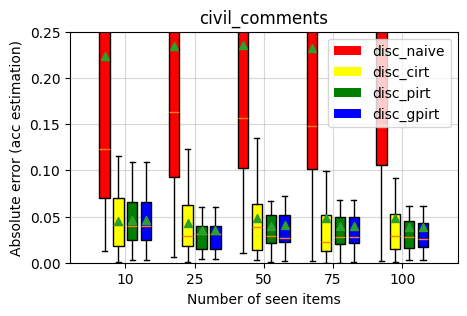

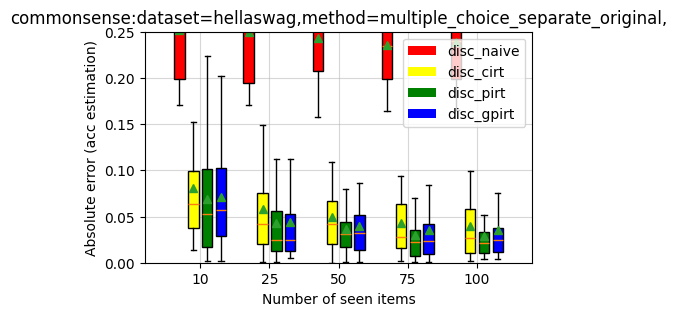

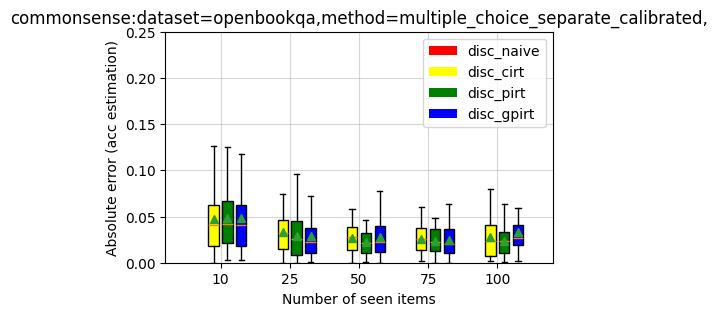

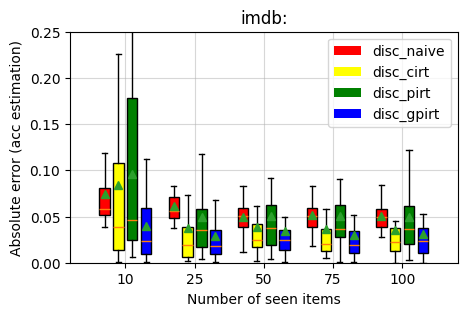

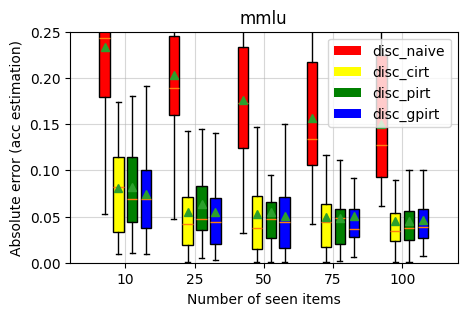

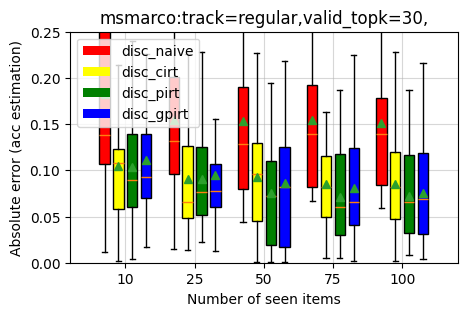

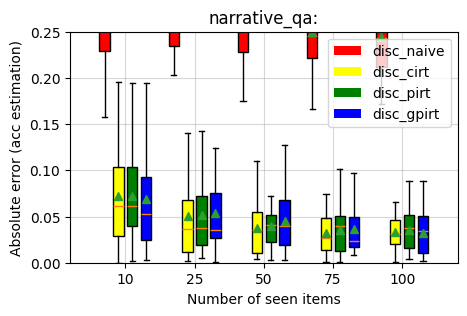

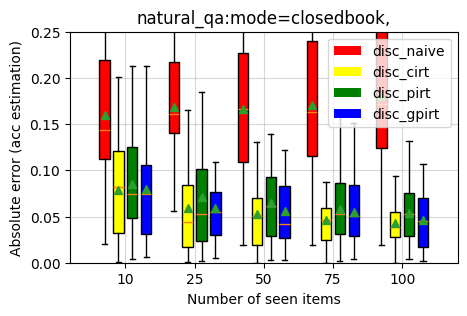

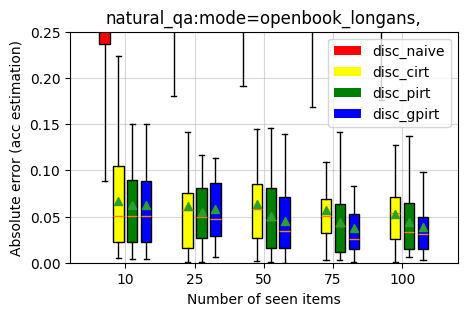

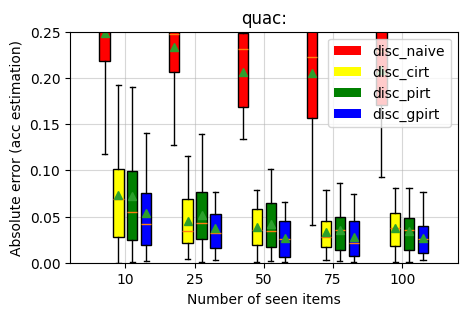

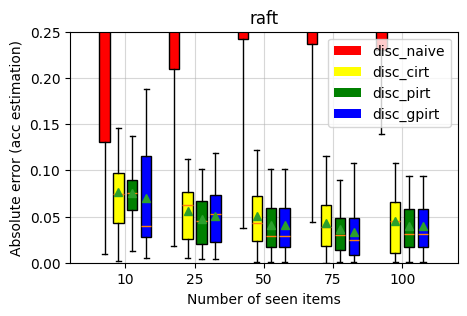

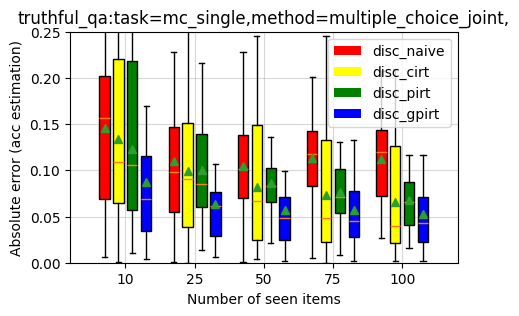

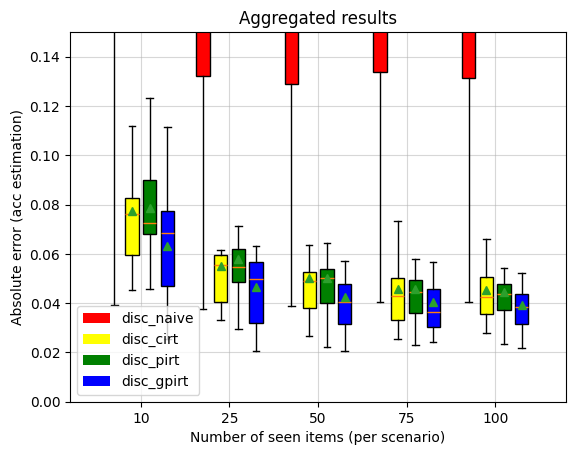

In [6]:
methods = ['disc_naive', 'disc_cirt', 'disc_pirt', 'disc_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)

In [7]:
scenarios = {'boolq:':['boolq:'],
             'civil_comments':['civil_comments:demographic=LGBTQ,',
                               'civil_comments:demographic=all,',
                               'civil_comments:demographic=black,',
                               'civil_comments:demographic=christian,',
                               'civil_comments:demographic=female,',
                               'civil_comments:demographic=male,',
                               'civil_comments:demographic=muslim,',
                               'civil_comments:demographic=other_religions,',
                               'civil_comments:demographic=white,'],
             'commonsense:dataset=hellaswag,method=multiple_choice_separate_original,':['commonsense:dataset=hellaswag,method=multiple_choice_separate_original,'],
             'commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,':['commonsense:dataset=openbookqa,method=multiple_choice_separate_calibrated,'],
             'imdb:':['imdb:'],
             'mmlu':['mmlu:subject=abstract_algebra,method=multiple_choice_joint,',
                     'mmlu:subject=college_chemistry,method=multiple_choice_joint,',
                     'mmlu:subject=computer_security,method=multiple_choice_joint,',
                     'mmlu:subject=econometrics,method=multiple_choice_joint,',
                     'mmlu:subject=us_foreign_policy,method=multiple_choice_joint,'],
             #'msmarco:track=regular,valid_topk=30,':['msmarco:track=regular,valid_topk=30,'],
             #'msmarco:track=trec,valid_topk=30,':['msmarco:track=trec,valid_topk=30,'],
             #'narrative_qa:':['narrative_qa:'],
             #'natural_qa:mode=closedbook,':['natural_qa:mode=closedbook,'],
             #'natural_qa:mode=openbook_longans,':['natural_qa:mode=openbook_longans,'],
             #'quac:':['quac:'],
             'raft':['raft:subset=ade_corpus_v2,',
                     'raft:subset=banking_77,',
                     'raft:subset=neurips_impact_statement_risks,',
                     'raft:subset=one_stop_english,',
                     'raft:subset=overruling,',
                     'raft:subset=semiconductor_org_types,',
                     'raft:subset=systematic_review_inclusion,',
                     'raft:subset=tai_safety_research,',
                     'raft:subset=terms_of_service,',
                     'raft:subset=tweet_eval_hate,',
                     'raft:subset=twitter_complaints,'],
             'truthful_qa:task=mc_single,method=multiple_choice_joint,':['truthful_qa:task=mc_single,method=multiple_choice_joint,']}
            

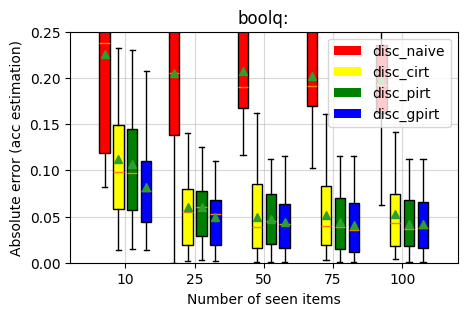

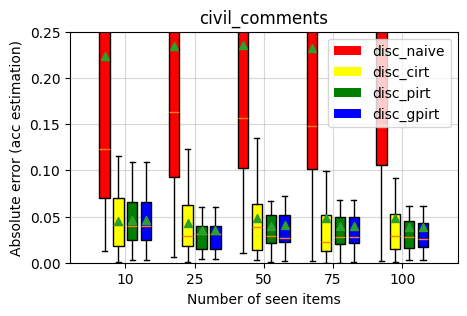

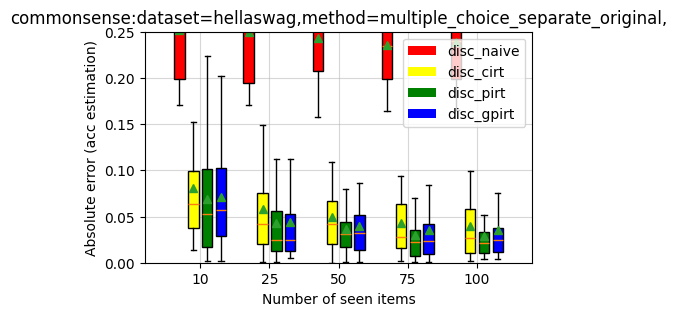

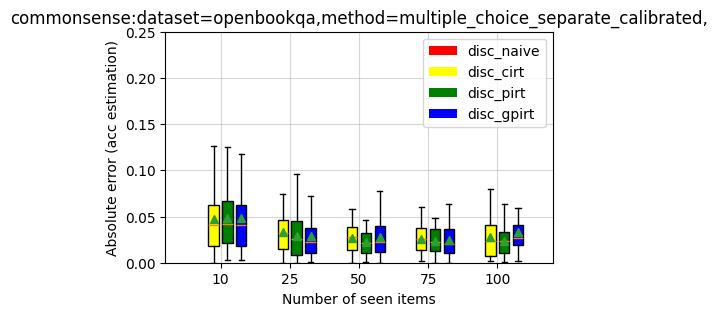

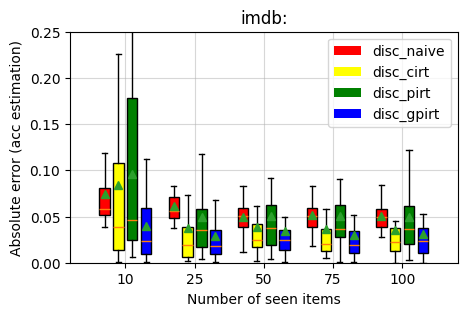

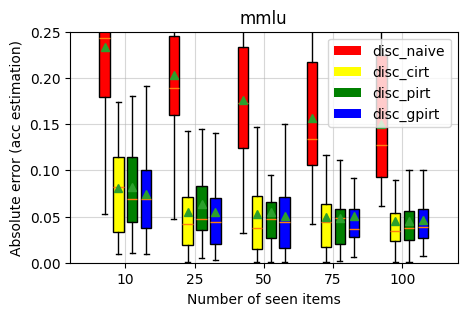

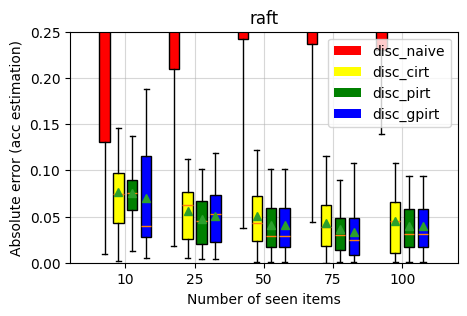

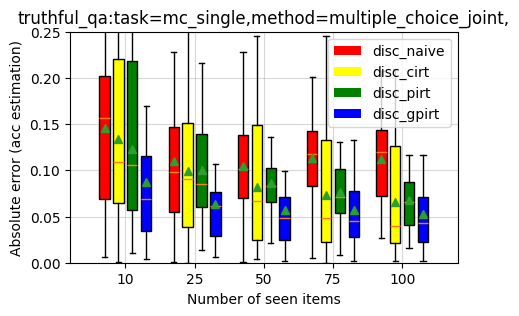

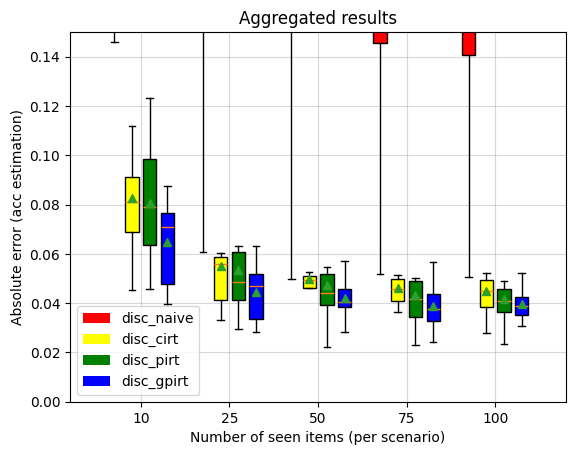

In [8]:
methods = ['disc_naive', 'disc_cirt', 'disc_pirt', 'disc_gpirt']
plot_results(results_full, scenarios.keys(), methods = methods)
plot_agg_results(results_full, scenarios.keys(), methods = methods)